In [33]:
import matplotlib.pyplot as plt
from hypertiling import HyperbolicTiling, TilingKernels
from hypertiling.graphics.plot import plot_tiling
from hypertiling.operators import adjacency
import networkx as nx
import numpy as np

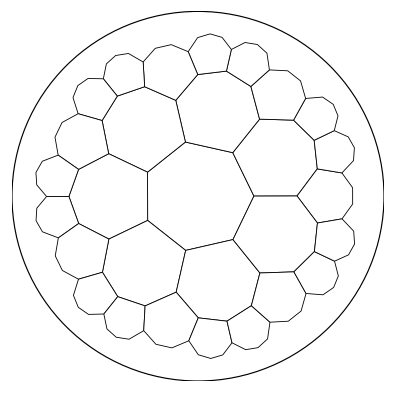

In [34]:
tiling = HyperbolicTiling(
    p=7, q=3, n=3,
    kernel=TilingKernels.StaticRotationalSector
)

plot_tiling(tiling, unitcircle=True, edgecolor="black", linewidth=0.5)
plt.show()

neighbors = tiling.get_nbrs_list(method="RO")

29


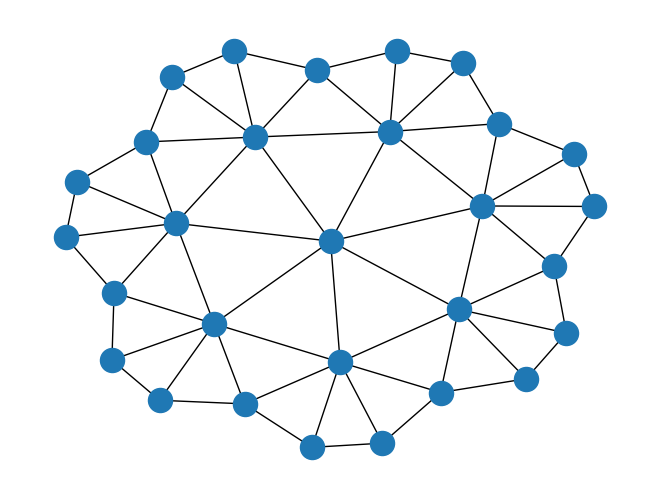

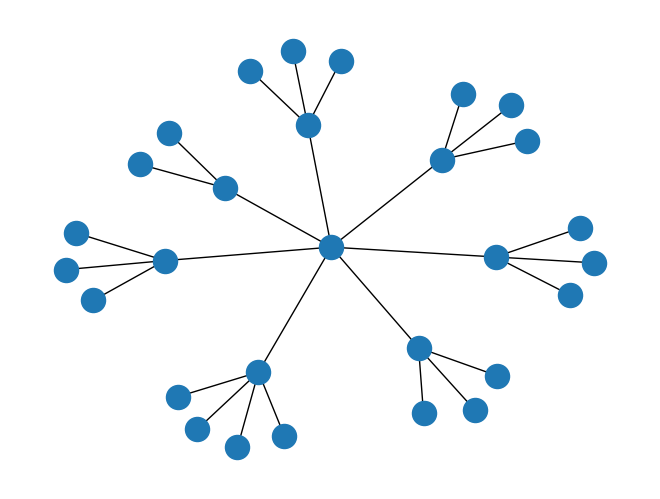

In [35]:
# Make a dual graph G corresponding to the tiling
V = len(tiling) # vertices = number of faces
print(V)
G = nx.Graph()
for u, nbrs in enumerate(neighbors):
    for v in nbrs:
        if u < v:
            G.add_edge(u, v)
nx.draw(G)
plt.show()

# Get a spanning tree of G
T = nx.minimum_spanning_tree(G) 
nx.draw(T)
plt.show()
tree_edges = set(T.edges()) 


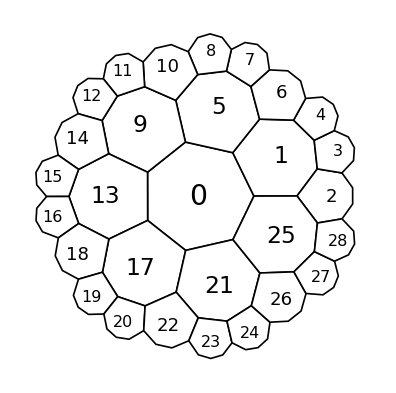

In [70]:
plot_tiling(tiling)
#layer_list = []
for poly in tiling.polygons:
    x, y = poly.get_center().real, poly.get_center().imag
    #layers = tiling.get_layer(poly)
    #layer_list.append(layers)
    plt.text(x, y, f"{poly.idx}", ha="center", va="center", fontsize=17*(1-0.7*np.abs(x*x+y*y)))
#print(layer_list)

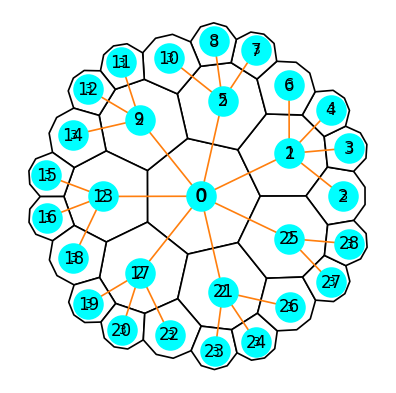

In [ ]:
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

poly_map = { poly.idx: poly for poly in tiling.polygons }

plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    l = tiling.get_layer(i)
    plt.text(x, y, str(l),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))

pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the layers match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()


- need a way to make a list of each edge on the regular graph and find the intersections between the spanning tree 
- edges and the regular graph edges
- also need a way to take each face and find the regular graph edges that comprise the face cycle
- then we need to go back and figure out what multiplicities to assign to each spanning tree edge and also assign said multiplicity
- to the corresponding regular edge
- separately use coordinates to properly assign a sign -1 or +1 to each regular graph edge
- call this function within the multiplicity assigner for the regular graph and multiply with the sign
- call the multiplicities into the face cycles and then sum over everything + multiply by global phase
- this will be the total flux through the plaquette
- now check that this flux is equal to the global phase for each plaquette
- if correct, the adjacency matrix can be built and the butterfly should be accurate

In [37]:
# First, we need to extract a list of edges for the regular tiling
edges = []
face_cycles = []
# iterate over cells
for poly in tiling:
    # extract vertex coordinates
    u = poly[1:]
    nv = len(u)

# loop over vertices/edges
    face_cycle_i = []
    for i in range(nv):
            # extract edges
            z1 = u[i]
            z2 = u[(i + 1) % nv]
            edge = (z1, z2)  
            edges.append(edge)
    face_cycle_i = edges.copy()
    face_cycles.append(face_cycle_i)
    #print(len(face_cycle_i))
#print(len(face_cycles))

# print(len(edges))

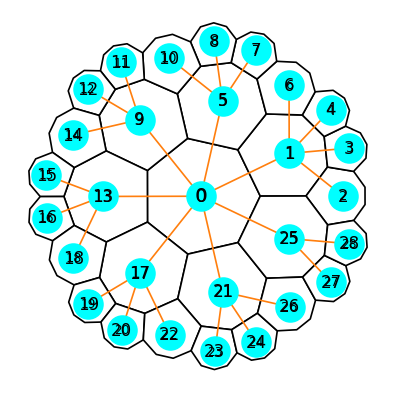

In [ ]:
# Find a way to assign the vertices of the spanning tree the same index as the faces on the tiling 

# take the spanning tree and turn it into a graph object for the overlay
T_idx = nx.Graph()
for u, v in T.edges():
    T_idx.add_edge(u, v)

# for every face in the tiling, obtain the corresponding index
poly_map = { poly.idx: poly for poly in tiling.polygons }

# tiling plot for the overlay with the associated indices on each face like before
plot_tiling(tiling)
for i, poly in poly_map.items():
    x, y = poly.get_center().real, poly.get_center().imag
    plt.text(x, y, str(i),
             ha="center", va="center",
             fontsize=12*(1 - 0.5 * (x**2 + y**2)**0.5))
# take the index of every node in the spanning tree and map it to the
# corresponding index of the face in the tiling
# account for the position of these numbers on the spanning tree for visual purposes
pos = { id: (poly_map[id].get_center().real,
               poly_map[id].get_center().imag)
        for id in T_idx.nodes() }
# plot the overlay of the tiling with the spanning tree - the indices of the faces and nodes match
nx.draw(T_idx, pos=pos,
        with_labels=True,
        node_color="cyan",
        edge_color="C1",
        font_size=10)

plt.axis("equal")
plt.show()


In [ ]:
# Now, I need to recursively define multiplicities associated with each edge of the spanning tree
# Then, I need to make sure that these multiplicities are associated with the right tiling edge
# After that, I need to pass that information into the face cycles so that I can obtain flux per plaquette